# Imagebits

## 1. EDA

- echilibrul claselor (train/test),
- variabilitate intra-clasă și inter-clasă (vizual + măsuri simple),
- particularități relevante pentru antrenare (normalizare, augmentări, riscuri de bias/shortcut, integritatea datelor).


In [1]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_ROOT = Path("/kaggle/input/imagebits-final/imagebits")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR  = DATA_ROOT / "test"

IMG_EXT = {".png"}

CLASSES = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])
CLASSES


['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

In [2]:
id_to_name = {
    "1": "airplane",
    "2": "bird",
    "3": "car",
    "4": "cat",
    "5": "deer",
    "6": "dog",
    "7": "horse",
    "8": "monkey",
    "9": "ship",
    "10": "truck",
}


- Indexarea dataset-ului



In [3]:
def collect_split(split_dir: Path, split_name: str) -> pd.DataFrame:
    rows = []
    for cls_dir in sorted([p for p in split_dir.iterdir() if p.is_dir()]):
        label = cls_dir.name
        for img_path in cls_dir.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in IMG_EXT:
                rows.append({"split": split_name, "label": label, "path": img_path})
    return pd.DataFrame(rows)

df = pd.concat([
    collect_split(TRAIN_DIR, "train"),
    collect_split(TEST_DIR, "test"),
], ignore_index=True)

df.head(), df.shape


(   split label                                               path
 0  train     1  /kaggle/input/imagebits-final/imagebits/train/...
 1  train     1  /kaggle/input/imagebits-final/imagebits/train/...
 2  train     1  /kaggle/input/imagebits-final/imagebits/train/...
 3  train     1  /kaggle/input/imagebits-final/imagebits/train/...
 4  train     1  /kaggle/input/imagebits-final/imagebits/train/...,
 (13000, 3))

- Echilibrul claselor



In [4]:
counts = df.groupby(["label","split"]).size().unstack("split").fillna(0).astype(int)
counts


split  test  train
label             
1       500    800
10      500    800
2       500    800
3       500    800
4       500    800
5       500    800
6       500    800
7       500    800
8       500    800
9       500    800

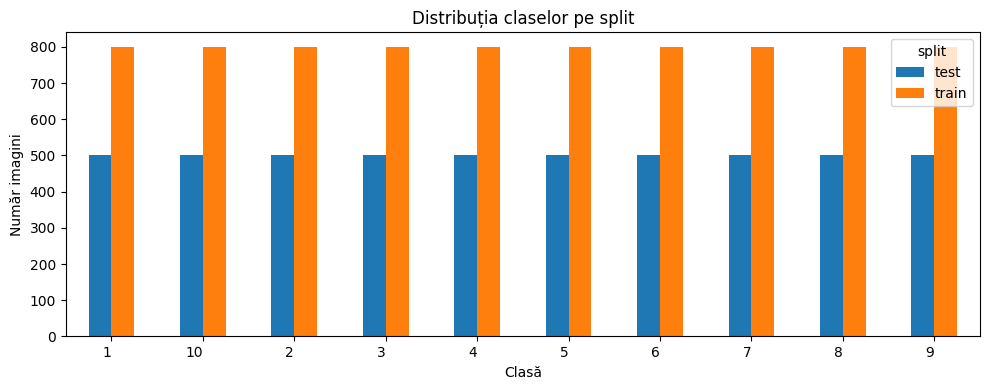

Total per split:
 split
train    8000
test     5000
Name: count, dtype: int64
Min/Max per split:
 split
test     500
train    800
dtype: int64 
 split
test     500
train    800
dtype: int64


In [5]:
ax = counts.plot(kind="bar", figsize=(10,4))
ax.set_title("Distribuția claselor pe split")
ax.set_xlabel("Clasă")
ax.set_ylabel("Număr imagini")
plt.xticks(rotation=1, ha="right")
plt.tight_layout()
plt.show()

print("Total per split:\n", df["split"].value_counts())
print("Min/Max per split:\n", counts.min(), "\n", counts.max())


- Integritatea datelor (sanity checks)



In [6]:
def safe_open(p: Path):
    try:
        with Image.open(p) as im:
            im.load()
            return im.size, im.mode, None
    except Exception as e:
        return None, None, str(e)

sample = df.sample(min(500, len(df)), random_state=RANDOM_SEED)
sizes, modes, errs = [], [], []

for p in sample["path"]:
    size, mode, err = safe_open(p)
    if err is not None:
        errs.append((p, err))
    else:
        sizes.append(size)
        modes.append(mode)

print("Erori (sample):", len(errs))
print("Dimensiuni unice (sample):", sorted(set(sizes))[:10], "| total:", len(set(sizes)))
print("Moduri unice (sample):", sorted(set(modes)))


Erori (sample): 0
Dimensiuni unice (sample): [(96, 96)] | total: 1
Moduri unice (sample): ['RGB']


- Variabilitate intra-clasă (analiză calitativă)



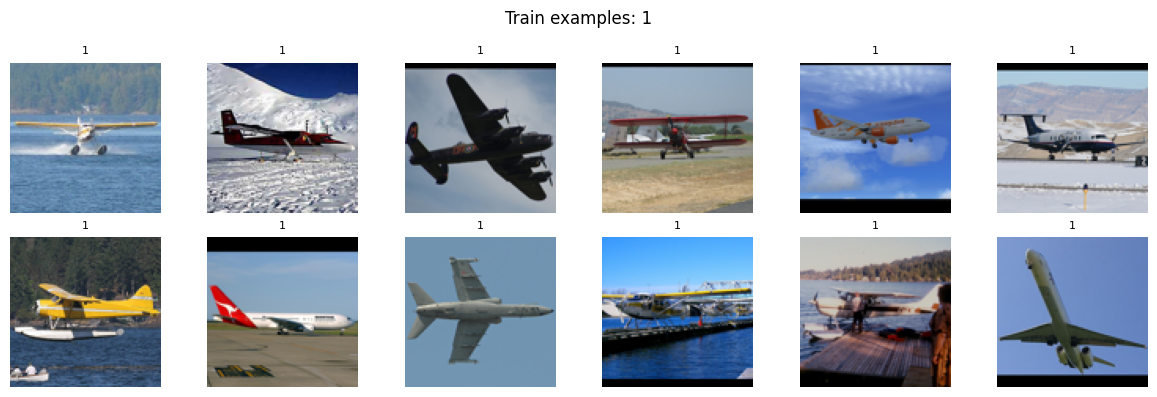

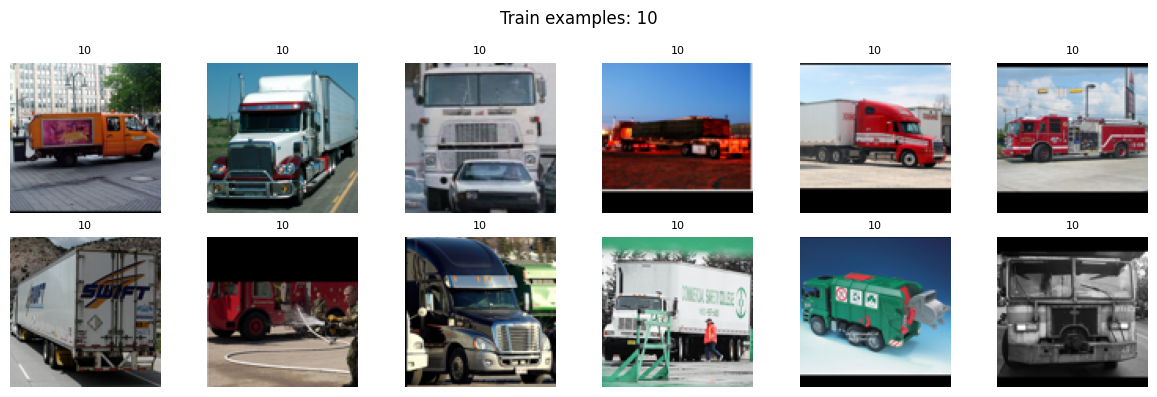

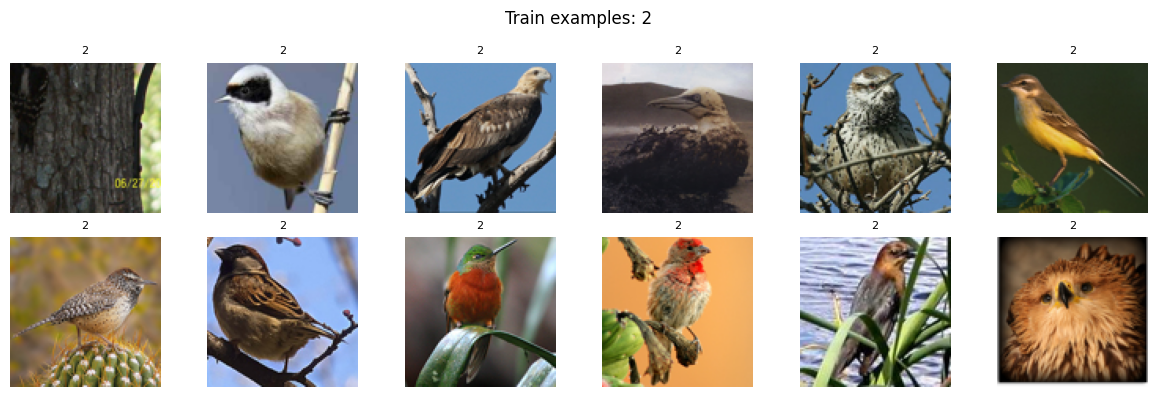

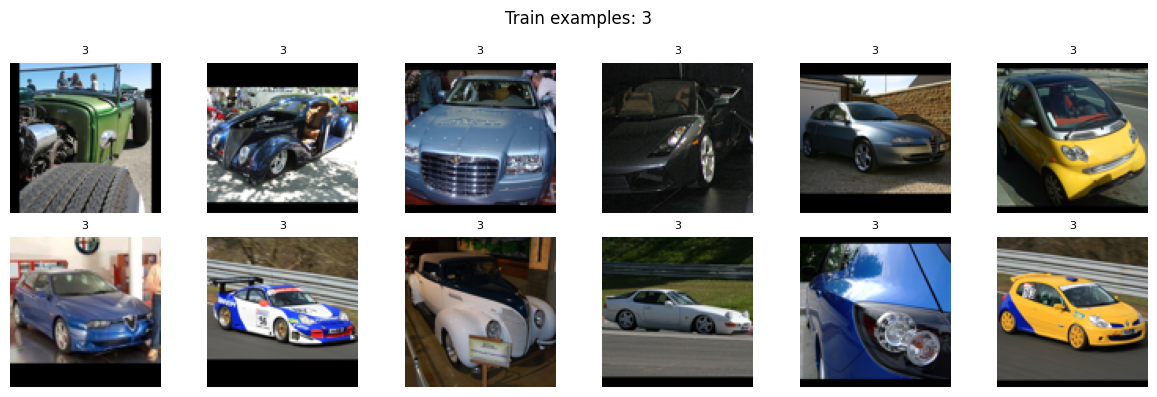

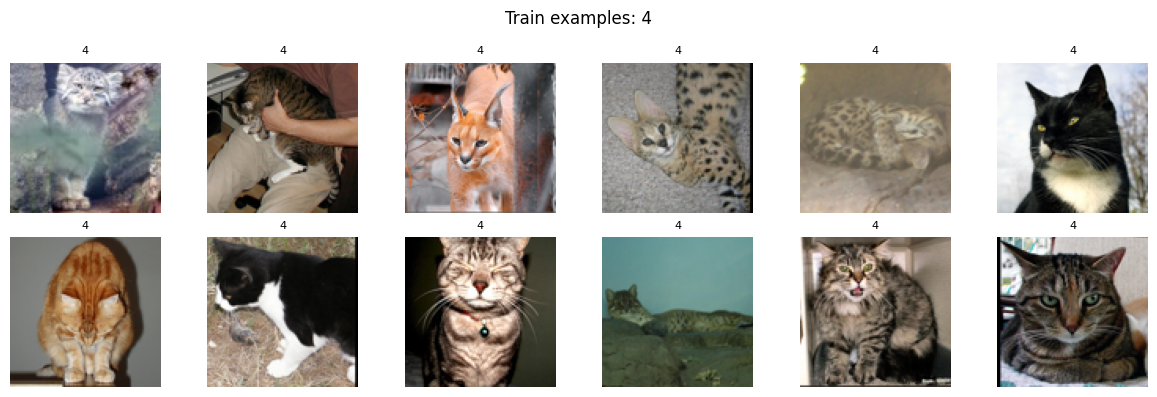

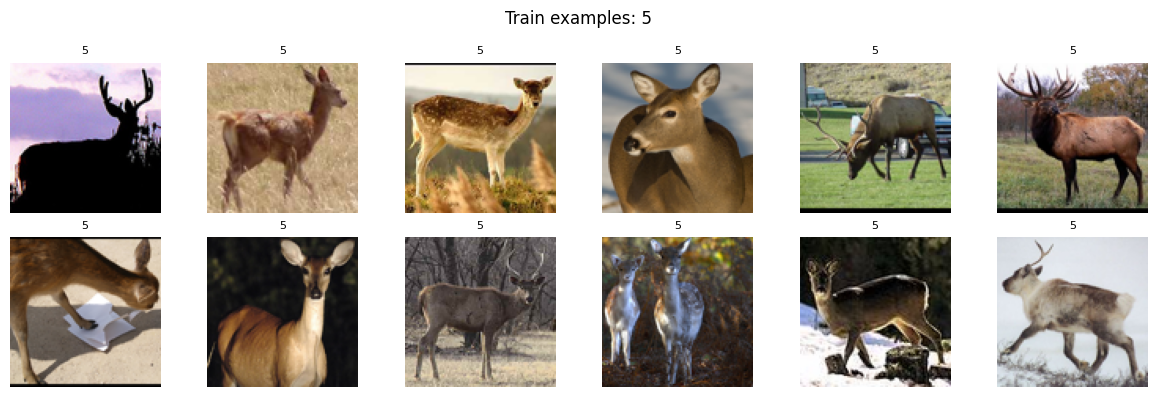

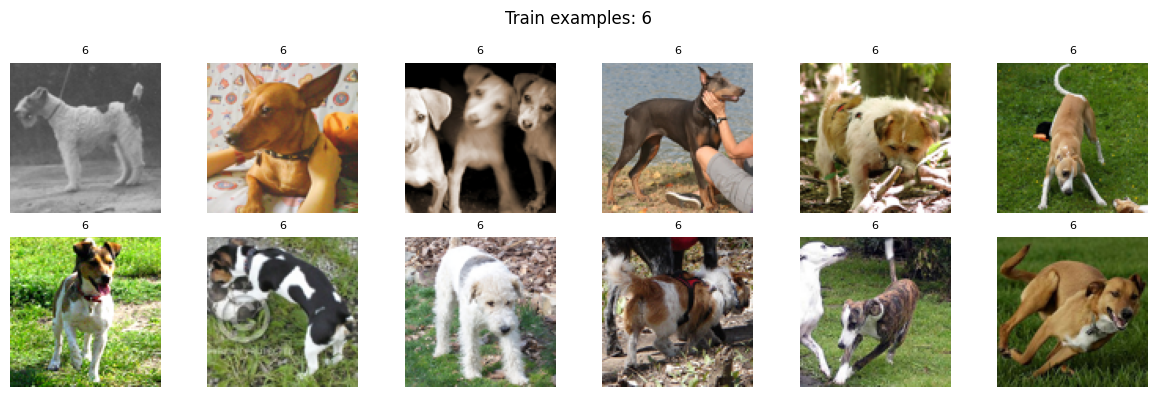

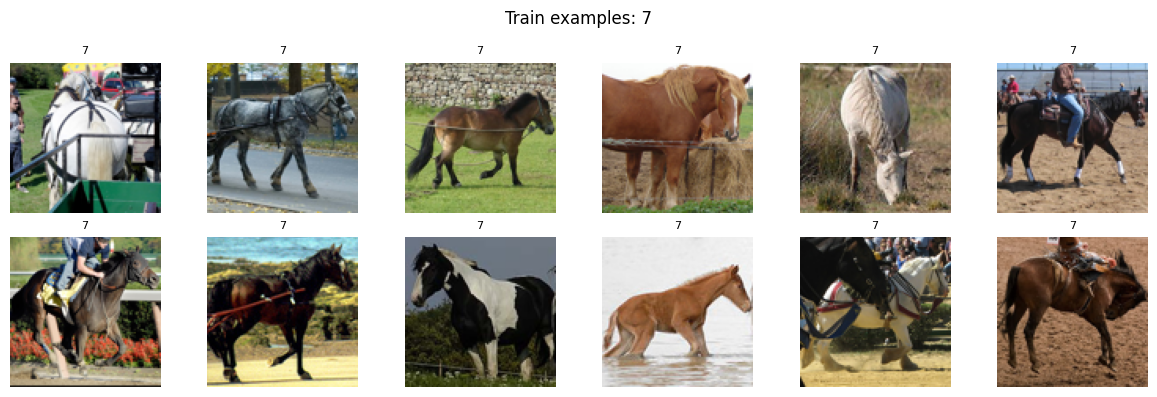

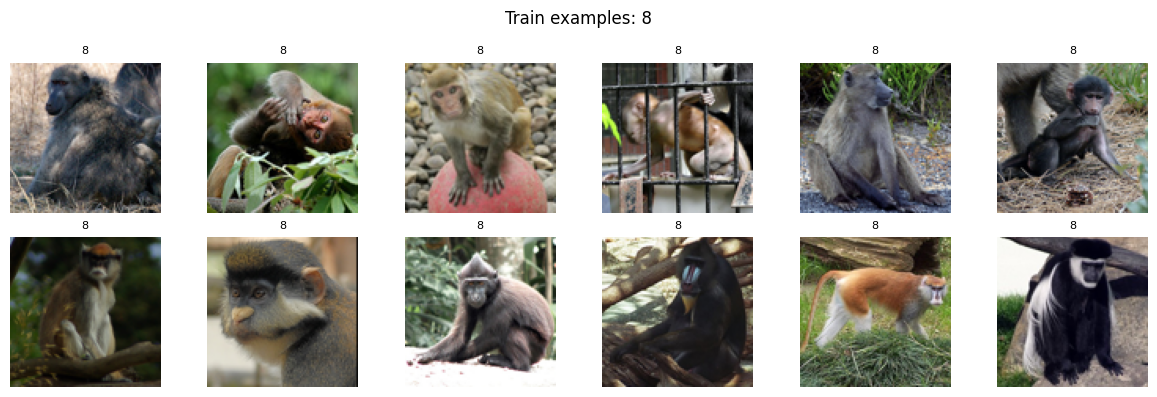

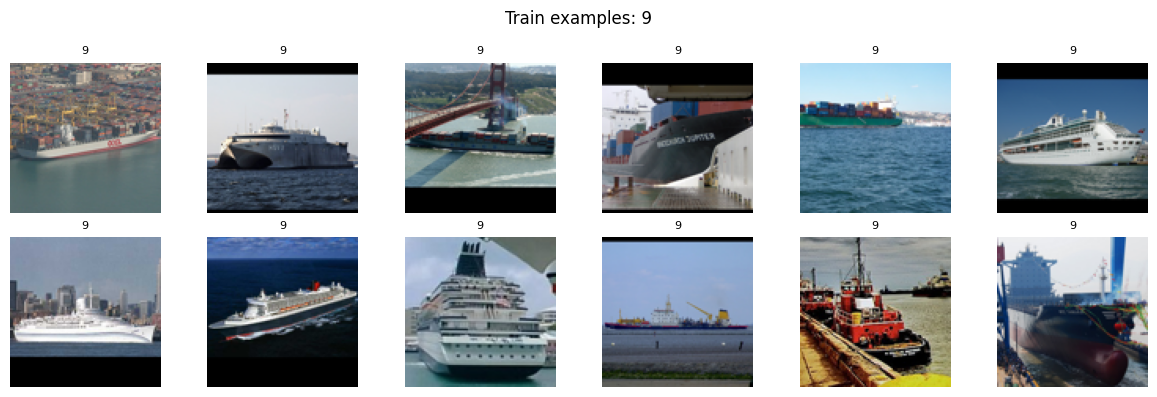

In [7]:
def show_grid(paths, title="", cols=6):
    paths = list(paths)
    rows = (len(paths) + cols - 1) // cols
    plt.figure(figsize=(cols*2, rows*2))
    for i, p in enumerate(paths, 1):
        im = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.axis("off")
        plt.title(p.parent.name, fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

for label in CLASSES:
    paths = df[(df.split=="train") & (df.label==label)].sample(12, random_state=RANDOM_SEED)["path"]
    show_grid(paths, title=f"Train examples: {label}", cols=6)


Rezultate privind variabilitate inter-clasă (clase confuzabile):

- cat vs dog (aspect similar la rezoluție mică),
- car vs truck (forme apropiate),
- airplane vs bird (silhouette/fundal),
- ship vs airplane (fundal uniform + obiect mic pe cer deci oarecum confuz).



In [8]:
def streaming_mean_std(paths, max_images=None):
    paths = list(paths)
    if max_images is not None:
        paths = random.sample(paths, min(max_images, len(paths)))

    n = 0
    s = np.zeros(3, dtype=np.float64)
    ss = np.zeros(3, dtype=np.float64)

    for p in tqdm(paths, desc="Mean/Std"):
        im = Image.open(p).convert("RGB")
        x = np.asarray(im, dtype=np.float32) / 255.0
        x = x.reshape(-1, 3)
        s  += x.sum(axis=0)
        ss += (x**2).sum(axis=0)
        n  += x.shape[0]

    mean = s / n
    var  = ss / n - mean**2
    std  = np.sqrt(np.maximum(var, 0))
    return mean, std

train_paths = df[df.split=="train"]["path"]
mean_rgb, std_rgb = streaming_mean_std(train_paths, max_images=None)
mean_rgb, std_rgb


Mean/Std:   0%|          | 0/8000 [00:00<?, ?it/s]

(array([0.44723113, 0.43964304, 0.40495838]),
 array([0.26056343, 0.2566603 , 0.26997221]))

Pentru a sustine observatiile facute mai sus legate de variabilitatea intra-clasa, vom calcula mean/std RGB si pentru fiecare clasa in parte

In [9]:
def mean_std_for_paths(paths, max_images=None):
    paths = list(paths)
    if max_images is not None:
        paths = random.sample(paths, min(max_images, len(paths)))

    n = 0
    s = np.zeros(3, dtype=np.float64)
    ss = np.zeros(3, dtype=np.float64)

    for p in paths:
        x = np.asarray(Image.open(p).convert("RGB"), dtype=np.float32) / 255.0
        x = x.reshape(-1,3)
        s  += x.sum(axis=0)
        ss += (x**2).sum(axis=0)
        n  += x.shape[0]

    mean = s / n
    var  = ss / n - mean**2
    std  = np.sqrt(np.maximum(var, 0))
    return mean, std

rows = []
for lab in sorted(df[df.split=="train"]["label"].unique()):
    paths = df[(df.split=="train") & (df.label==lab)]["path"].tolist()
    mean, std = mean_std_for_paths(paths, max_images=400)  # sample ca să fie rapid
    rows.append({
        "label": lab,
        "mean_R": mean[0], "mean_G": mean[1], "mean_B": mean[2],
        "std_R": std[0], "std_G": std[1], "std_B": std[2],
        "n": len(paths)
    })

cls_stats = pd.DataFrame(rows).sort_values("label")
cls_stats


label    mean_R    mean_G    mean_B     std_R     std_G     std_B    n
0     1  0.490771  0.532107  0.564857  0.250537  0.246101  0.273656  800
1    10  0.404159  0.394717  0.387995  0.296289  0.295330  0.306725  800
2     2  0.464898  0.468423  0.414710  0.243074  0.238052  0.268820  800
3     3  0.374752  0.357669  0.342164  0.290155  0.277777  0.281619  800
4     4  0.453771  0.423144  0.369643  0.247446  0.238883  0.237293  800
5     5  0.481395  0.462214  0.365076  0.224815  0.215984  0.216353  800
6     6  0.475007  0.446250  0.393310  0.258485  0.250720  0.254163  800
7     7  0.442497  0.415351  0.359125  0.253572  0.250601  0.249496  800
8     8  0.441695  0.428103  0.358018  0.245067  0.238146  0.236186  800
9     9  0.439472  0.461242  0.485637  0.274105  0.275069  0.289993  800

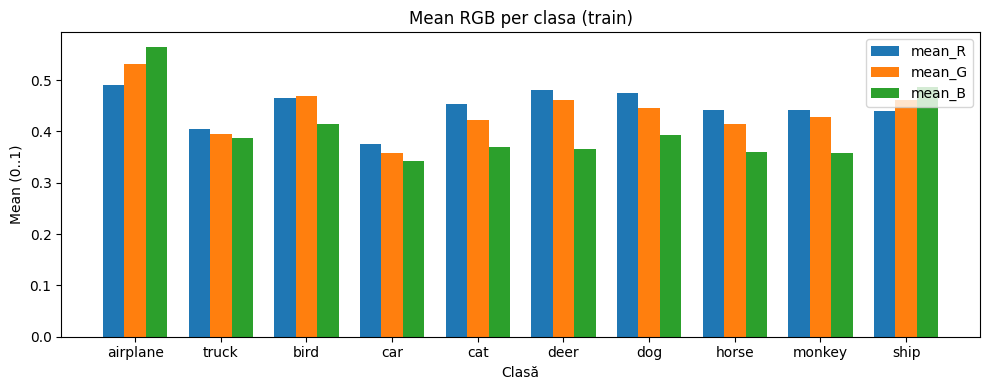

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

labels = cls_stats["label"].astype(str).map(id_to_name).values
x = np.arange(len(labels))
w = 0.25

plt.figure(figsize=(10,4))
plt.bar(x - w, cls_stats["mean_R"], width=w, label="mean_R")
plt.bar(x,     cls_stats["mean_G"], width=w, label="mean_G")
plt.bar(x + w, cls_stats["mean_B"], width=w, label="mean_B")
plt.xticks(x, labels)
plt.xlabel("Clasă")
plt.ylabel("Mean (0..1)")
plt.title("Mean RGB per clasa (train)")
plt.legend()
plt.tight_layout()
plt.show()


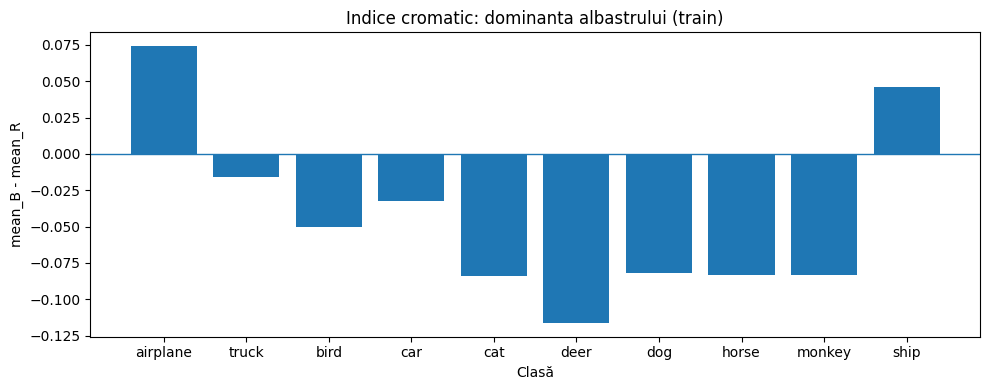

In [11]:
cls_stats["blue_minus_red"] = cls_stats["mean_B"] - cls_stats["mean_R"]

plt.figure(figsize=(10,4))
plt.bar(labels, cls_stats["blue_minus_red"])
plt.axhline(0, linewidth=1)
plt.xlabel("Clasă")
plt.ylabel("mean_B - mean_R")
plt.title("Indice cromatic: dominanta albastrului (train)")
plt.tight_layout()
plt.show()


- Train vs Test: verificare de distribuție (brightness / contrast)


BC stats:   0%|          | 0/4000 [00:00<?, ?it/s]

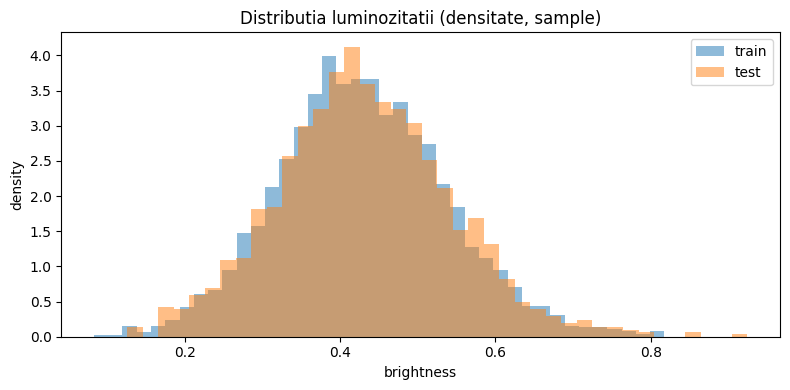

In [12]:
def brightness_contrast(p: Path):
    im = Image.open(p).convert("RGB")
    x = np.asarray(im, dtype=np.float32) / 255.0
    return float(x.mean()), float(x.std())

df_bc = df.sample(min(4000, len(df)), random_state=RANDOM_SEED).copy()
bc = np.array([brightness_contrast(p) for p in tqdm(df_bc["path"], desc="BC stats")])
df_bc["brightness"] = bc[:,0]
df_bc["contrast"] = bc[:,1]

plt.figure(figsize=(8,4))
for split in ["train","test"]:
    subset = df_bc[df_bc.split==split]
    plt.hist(subset["brightness"], bins=40, alpha=0.5, label=split, density=True)
plt.title("Distributia luminozitatii (densitate, sample)")
plt.xlabel("brightness"); plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
def average_hash(p: Path, hash_size=8):
    im = Image.open(p).convert("L").resize((hash_size, hash_size))
    x = np.asarray(im, dtype=np.float32)
    bits = (x > x.mean()).astype(np.uint8).flatten()
    return "".join(bits.astype(str))

train_s = df[df.split=="train"].sample(3000, random_state=RANDOM_SEED)
test_s  = df[df.split=="test"].sample(3000, random_state=RANDOM_SEED)

train_hashes = set(average_hash(p) for p in tqdm(train_s["path"], desc="train hash"))
test_hashes  = set(average_hash(p) for p in tqdm(test_s["path"],  desc="test hash"))

overlap = train_hashes & test_hashes
print("Overlap train-test (aHash, sample):", len(overlap))


train hash:   0%|          | 0/3000 [00:00<?, ?it/s]

test hash:   0%|          | 0/3000 [00:00<?, ?it/s]

Overlap train-test (aHash, sample): 21


hash map train:   0%|          | 0/3000 [00:00<?, ?it/s]

hash map test:   0%|          | 0/3000 [00:00<?, ?it/s]

Overlap hashes: 21
[0] hash=000000001111... train=1471.png test=1412.png


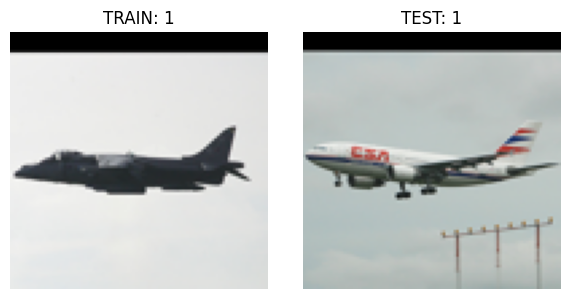

[1] hash=111111111111... train=202.png test=530.png


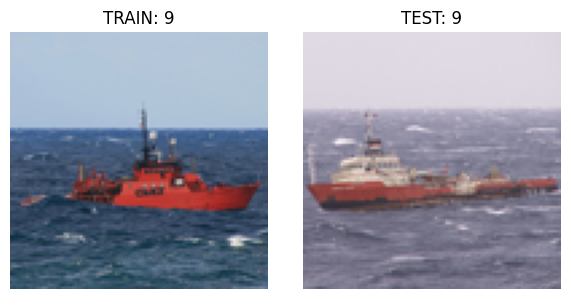

[2] hash=000000000000... train=2489.png test=2077.png


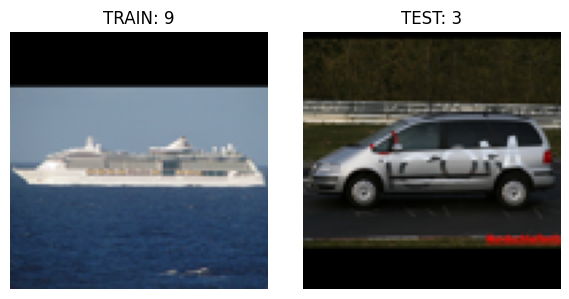

[3] hash=111111111111... train=4751.png test=2982.png


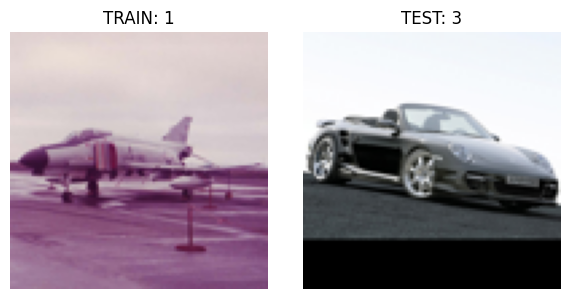

[4] hash=111111111111... train=4958.png test=4260.png


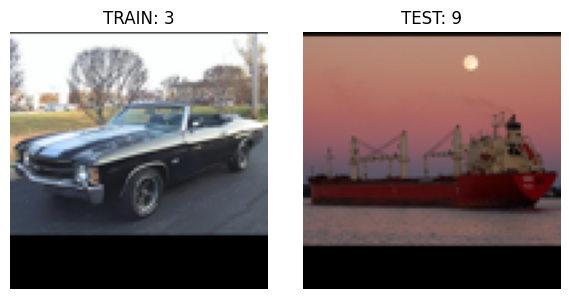

In [ ]:
from collections import defaultdict

def build_hash_map(df_split, n=3000):
    subset = df_split.sample(min(n, len(df_split)), random_state=RANDOM_SEED)
    hm = defaultdict(list)
    for p in tqdm(subset["path"], desc=f"hash map {subset.iloc[0]['split']}"):
        h = average_hash(p)
        hm[h].append(p)
    return hm

train_map = build_hash_map(df[df.split=="train"], n=3000)
test_map  = build_hash_map(df[df.split=="test"],  n=3000)

overlap = set(train_map.keys()) & set(test_map.keys())
print("Overlap hashes:", len(overlap))

def show_pair(train_p, test_p):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(Image.open(train_p).convert("RGB")); plt.axis("off")
    plt.title(f"TRAIN: {train_p.parent.name}")
    plt.subplot(1,2,2); plt.imshow(Image.open(test_p).convert("RGB")); plt.axis("off")
    plt.title(f"TEST: {test_p.parent.name}")
    plt.tight_layout()
    plt.show()

for i, h in enumerate(list(overlap)[:5]):
    tp = train_map[h][0]
    xp = test_map[h][0]
    print(f"[{i}] hash={h[:12]}... train={tp.name} test={xp.name}")
    show_pair(tp, xp)


## Pregatire date pentru rularea modelelor - SPLIT pe TRAIN

In [15]:
from sklearn.model_selection import train_test_split

df_train_full = df[df.split=="train"].copy()

train_idx, val_idx = train_test_split(
    df_train_full.index,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df_train_full["label"]
)

df_train = df_train_full.loc[train_idx].reset_index(drop=True)
df_val   = df_train_full.loc[val_idx].reset_index(drop=True)
df_test  = df[df.split=="test"].reset_index(drop=True)


# 2. MLP pe Imagebits

1) Construim un baseline MLP pentru clasificare
2) Folosim split intern train/val (stratificat) deoarece dataset-ul oferă doar train/test.
3) Comparam antrenarea fara augmentări vs. cu augmentări (Albumentations) pe aceleași grafice.


In [16]:
import random, numpy as np, pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Etichete + normalizare

Mapăm etichetele la indici 0..9.


In [ ]:
labels_sorted = sorted(df_train_full["label"].unique(), key=lambda x: int(x) if str(x).isdigit() else str(x))
label_to_idx = {lab:i for i, lab in enumerate(labels_sorted)}
idx_to_label = {i:lab for lab,i in label_to_idx.items()}
num_classes = len(label_to_idx)

mean_rgb = np.array([0.44723113, 0.43964304, 0.40495838], dtype=np.float32)
std_rgb  = np.array([0.26056343, 0.2566603 , 0.26997221], dtype=np.float32)

label_to_idx, num_classes


({'1': 0,
  '2': 1,
  '3': 2,
  '4': 3,
  '5': 4,
  '6': 5,
  '7': 6,
  '8': 7,
  '9': 8,
  '10': 9},
 10)

## Transformări (Albumentations)

- Fără augmentări: doar normalizare.
- Cu augmentări: flip orizontal + mici variații de culoare + mici transformări geometrice.


In [ ]:
import albumentations as A

tfm_noaug = A.Compose([
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])

tfm_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
class ImageBitsDataset(Dataset):
    def __init__(self, df, transform, flatten=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.flatten = flatten

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        p = self.df.loc[i, "path"]
        y = label_to_idx[self.df.loc[i, "label"]]

        img = np.array(Image.open(p).convert("RGB")) 
        out = self.transform(image=img)["image"]     
        x = torch.from_numpy(out).permute(2,0,1).float() 

        if self.flatten:
            x = x.reshape(-1) 

        return x, torch.tensor(y, dtype=torch.long)

dummy_x, _ = ImageBitsDataset(df_train.head(1), tfm_noaug)[0]
dummy_x.shape


torch.Size([27648])

In [ ]:
# CNN
x0, y0 = ImageBitsDataset(df_train, tfm_noaug, flatten=False)[0]
print("CNN sample:", x0.shape) 

# MLP
x1, y1 = ImageBitsDataset(df_train, tfm_noaug, flatten=True)[0]
print("MLP sample:", x1.shape)


CNN sample: torch.Size([3, 96, 96])
MLP sample: torch.Size([27648])


In [ ]:
BATCH_SIZE = 128

train_loader_noaug = DataLoader(ImageBitsDataset(df_train, tfm_noaug, flatten=True), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_noaug   = DataLoader(ImageBitsDataset(df_val, tfm_noaug, flatten=True),   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train_loader_aug = DataLoader(ImageBitsDataset(df_train, tfm_aug, flatten=True), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_aug   = DataLoader(ImageBitsDataset(df_val, tfm_noaug, flatten=True), batch_size=BATCH_SIZE, shuffle=False, num_workers=2) 


## Arhitectură MLP (baseline)

MLP - imaginea flatten 

- 2-3 straturi
- BatchNorm + Dropout
- AdamW + weight decay 


In [22]:
class MLP(nn.Module):
    def __init__(self, in_dim, num_classes, hidden1=1024, hidden2=512, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

in_dim = dummy_x.numel()
model = MLP(in_dim=in_dim, num_classes=num_classes).to(device)
sum(p.numel() for p in model.parameters())/1e6


28.845578

In [ ]:
def run_epoch(model, loader, optimizer=None):
    train = optimizer is not None
    model.train(train)

    losses = []
    all_y, all_p = [], []

    criterion = nn.CrossEntropyLoss()

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        preds = logits.argmax(dim=1)

        all_y.append(y.detach().cpu().numpy())
        all_p.append(preds.detach().cpu().numpy())

    all_y = np.concatenate(all_y)
    all_p = np.concatenate(all_p)

    acc = accuracy_score(all_y, all_p)
    f1  = f1_score(all_y, all_p, average="macro")
    return float(np.mean(losses)), acc, f1

def train_model(train_loader, val_loader,
                hidden1=1024, hidden2=512, dropout=0.3,
                epochs=50, lr=1e-3, weight_decay=1e-4,
                patience=7, min_delta=1e-4):

    model = MLP(in_dim=in_dim, num_classes=num_classes,
                hidden1=hidden1, hidden2=hidden2, dropout=dropout).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

    best_val = -1.0
    best_state = None
    best_epoch = None
    best_snapshot = None 
    bad_epochs = 0

    stopped_early = False

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer=optimizer)
        va_loss, va_acc, va_f1 = run_epoch(model, val_loader, optimizer=None)

        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        history["train_f1"].append(tr_f1);     history["val_f1"].append(va_f1)

        improved = (va_f1 > best_val + min_delta)
        if improved:
            best_val = va_f1
            best_epoch = ep
            best_snapshot = {
                "train_loss": tr_loss, "train_acc": tr_acc, "train_f1": tr_f1,
                "val_loss": va_loss,   "val_acc": va_acc,   "val_f1": va_f1
            }
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1

        print(f"Epoch {ep:02d} | train loss {tr_loss:.3f} acc {tr_acc:.3f} f1 {tr_f1:.3f} "
              f"| val loss {va_loss:.3f} acc {va_acc:.3f} f1 {va_f1:.3f} "
              f"| bad_epochs={bad_epochs}/{patience}")

        if bad_epochs >= patience:
            stopped_early = True
            print(f"Early stopping: no val_f1 improvement for {patience} epochs.")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    if best_snapshot is None:
        print("Training finished, but no valid improvement was recorded (check for NaNs).")
    else:
        why = "EARLY STOP" if stopped_early else "FULL RUN"
        print(
            f"[{why}] Best epoch = {best_epoch:02d} | "
            f"train: loss {best_snapshot['train_loss']:.3f} acc {best_snapshot['train_acc']:.3f} f1 {best_snapshot['train_f1']:.3f} | "
            f"val: loss {best_snapshot['val_loss']:.3f} acc {best_snapshot['val_acc']:.3f} f1 {best_snapshot['val_f1']:.3f}"
        )

    history["best_epoch"] = best_epoch
    history["best_val_f1"] = float(best_val) if best_snapshot is not None else None

    return model, history



- experiment fara augmentari

In [24]:
mlp_noaug, hist_noaug = train_model(train_loader_noaug, val_loader_noaug, hidden1=1024, hidden2=512, dropout=0.3, epochs=30, lr=1e-3, weight_decay=1e-4)

Epoch 01 | train loss 1.850 acc 0.316 f1 0.311 | val loss 1.698 acc 0.358 f1 0.353 | bad_epochs=0/7
Epoch 02 | train loss 1.632 acc 0.395 f1 0.390 | val loss 1.651 acc 0.371 f1 0.363 | bad_epochs=0/7
Epoch 03 | train loss 1.497 acc 0.451 f1 0.446 | val loss 1.609 acc 0.411 f1 0.403 | bad_epochs=0/7
Epoch 04 | train loss 1.364 acc 0.503 f1 0.500 | val loss 1.604 acc 0.421 f1 0.416 | bad_epochs=0/7
Epoch 05 | train loss 1.225 acc 0.562 f1 0.559 | val loss 1.657 acc 0.404 f1 0.400 | bad_epochs=1/7
Epoch 06 | train loss 1.094 acc 0.612 f1 0.610 | val loss 1.660 acc 0.410 f1 0.408 | bad_epochs=2/7
Epoch 07 | train loss 0.944 acc 0.669 f1 0.667 | val loss 1.705 acc 0.433 f1 0.433 | bad_epochs=0/7
Epoch 08 | train loss 0.833 acc 0.709 f1 0.709 | val loss 1.705 acc 0.424 f1 0.425 | bad_epochs=1/7
Epoch 09 | train loss 0.738 acc 0.742 f1 0.741 | val loss 1.793 acc 0.431 f1 0.426 | bad_epochs=2/7
Epoch 10 | train loss 0.638 acc 0.774 f1 0.774 | val loss 1.853 acc 0.439 f1 0.442 | bad_epochs=0/7


- experiment cu augmentari

In [33]:
mlp_aug, hist_aug = train_model(train_loader_aug, val_loader_aug,hidden1=1024, hidden2=512, dropout=0.3, epochs=30, lr=1e-3, weight_decay=1e-4)

Epoch 01 | train loss 1.933 acc 0.285 f1 0.278 | val loss 1.744 acc 0.339 f1 0.320 | bad_epochs=0/7
Epoch 02 | train loss 1.761 acc 0.347 f1 0.340 | val loss 1.696 acc 0.367 f1 0.354 | bad_epochs=0/7
Epoch 03 | train loss 1.685 acc 0.369 f1 0.362 | val loss 1.627 acc 0.386 f1 0.377 | bad_epochs=0/7
Epoch 04 | train loss 1.635 acc 0.397 f1 0.391 | val loss 1.616 acc 0.398 f1 0.374 | bad_epochs=1/7
Epoch 05 | train loss 1.599 acc 0.410 f1 0.403 | val loss 1.589 acc 0.401 f1 0.385 | bad_epochs=0/7
Epoch 06 | train loss 1.547 acc 0.433 f1 0.427 | val loss 1.572 acc 0.416 f1 0.405 | bad_epochs=0/7
Epoch 07 | train loss 1.521 acc 0.443 f1 0.437 | val loss 1.539 acc 0.439 f1 0.422 | bad_epochs=0/7
Epoch 08 | train loss 1.490 acc 0.452 f1 0.445 | val loss 1.537 acc 0.445 f1 0.436 | bad_epochs=0/7
Epoch 09 | train loss 1.460 acc 0.463 f1 0.458 | val loss 1.535 acc 0.438 f1 0.435 | bad_epochs=1/7
Epoch 10 | train loss 1.440 acc 0.476 f1 0.471 | val loss 1.587 acc 0.431 f1 0.425 | bad_epochs=2/7


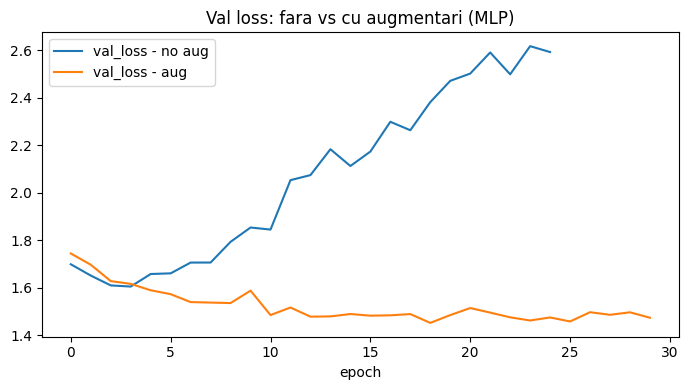

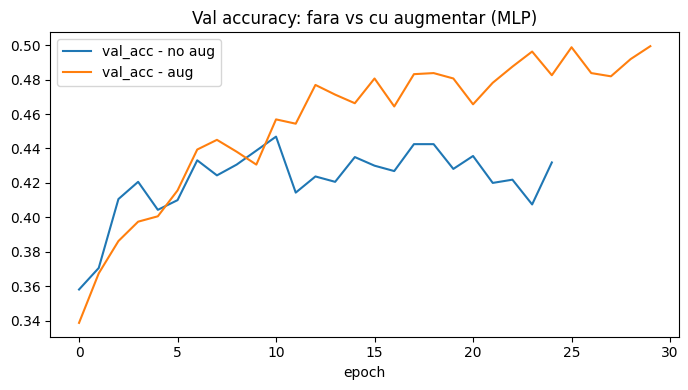

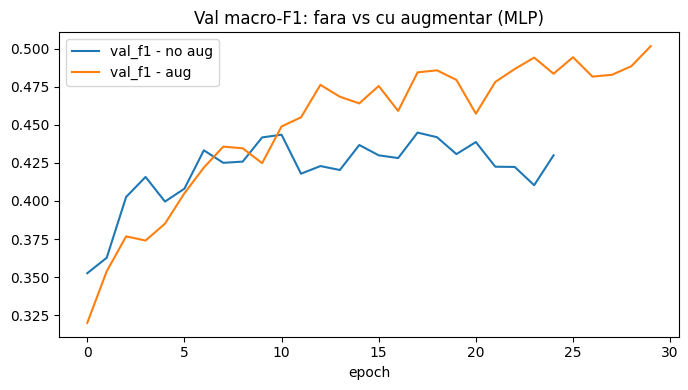

In [34]:
def plot_compare(hist1, hist2, key, title):
    plt.figure(figsize=(7,4))
    plt.plot(hist1[key], label=f"{key} - no aug")
    plt.plot(hist2[key], label=f"{key} - aug")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_compare(hist_noaug, hist_aug, "val_loss", "Val loss: fara vs cu augmentari (MLP)")
plot_compare(hist_noaug, hist_aug, "val_acc",  "Val accuracy: fara vs cu augmentar (MLP)")
plot_compare(hist_noaug, hist_aug, "val_f1",   "Val macro-F1: fara vs cu augmentar (MLP)")


Se poate observa ca modelul fara augmentari este clar un overfitting puternic, asa ca in continuare vom alege sa analizam doar modelul cu augmentari.
- MLP are multi parametri deci putem incerca sa oferim straturilor hidden mai putini neuroni
- schimbam weight decay si dropout pentru a observa si alte rezultate

In [35]:
mlp_aug_small, hist_aug_small = train_model(train_loader_aug, val_loader_aug,hidden1=512, hidden2=256, dropout=0.4, epochs=50, lr=1e-3, weight_decay=1e-4)

Epoch 01 | train loss 1.994 acc 0.265 f1 0.255 | val loss 1.794 acc 0.333 f1 0.315 | bad_epochs=0/7
Epoch 02 | train loss 1.821 acc 0.325 f1 0.317 | val loss 1.714 acc 0.358 f1 0.350 | bad_epochs=0/7
Epoch 03 | train loss 1.753 acc 0.351 f1 0.344 | val loss 1.673 acc 0.381 f1 0.361 | bad_epochs=0/7
Epoch 04 | train loss 1.710 acc 0.368 f1 0.360 | val loss 1.630 acc 0.403 f1 0.394 | bad_epochs=0/7
Epoch 05 | train loss 1.670 acc 0.381 f1 0.374 | val loss 1.605 acc 0.409 f1 0.405 | bad_epochs=0/7
Epoch 06 | train loss 1.631 acc 0.400 f1 0.395 | val loss 1.578 acc 0.405 f1 0.396 | bad_epochs=1/7
Epoch 07 | train loss 1.621 acc 0.397 f1 0.389 | val loss 1.568 acc 0.424 f1 0.415 | bad_epochs=0/7
Epoch 08 | train loss 1.600 acc 0.415 f1 0.407 | val loss 1.551 acc 0.428 f1 0.414 | bad_epochs=1/7
Epoch 09 | train loss 1.570 acc 0.417 f1 0.410 | val loss 1.529 acc 0.434 f1 0.420 | bad_epochs=0/7
Epoch 10 | train loss 1.549 acc 0.431 f1 0.425 | val loss 1.523 acc 0.434 f1 0.425 | bad_epochs=0/7


In [36]:
mlp_aug_small_lr, hist_aug_small_lr = train_model(
    train_loader_aug, val_loader_aug,
    hidden1=512, hidden2=256, dropout=0.4,
    epochs=60, lr=3e-4, weight_decay=1e-4, patience=7
)


Epoch 01 | train loss 1.995 acc 0.270 f1 0.263 | val loss 1.796 acc 0.344 f1 0.320 | bad_epochs=0/7
Epoch 02 | train loss 1.830 acc 0.327 f1 0.318 | val loss 1.726 acc 0.358 f1 0.345 | bad_epochs=0/7
Epoch 03 | train loss 1.762 acc 0.347 f1 0.338 | val loss 1.684 acc 0.375 f1 0.362 | bad_epochs=0/7
Epoch 04 | train loss 1.720 acc 0.364 f1 0.355 | val loss 1.654 acc 0.389 f1 0.381 | bad_epochs=0/7
Epoch 05 | train loss 1.690 acc 0.380 f1 0.373 | val loss 1.614 acc 0.400 f1 0.386 | bad_epochs=0/7
Epoch 06 | train loss 1.657 acc 0.394 f1 0.386 | val loss 1.597 acc 0.404 f1 0.387 | bad_epochs=0/7
Epoch 07 | train loss 1.620 acc 0.400 f1 0.392 | val loss 1.570 acc 0.422 f1 0.413 | bad_epochs=0/7
Epoch 08 | train loss 1.593 acc 0.421 f1 0.413 | val loss 1.556 acc 0.427 f1 0.422 | bad_epochs=0/7
Epoch 09 | train loss 1.598 acc 0.414 f1 0.408 | val loss 1.553 acc 0.428 f1 0.419 | bad_epochs=1/7
Epoch 10 | train loss 1.570 acc 0.422 f1 0.415 | val loss 1.532 acc 0.444 f1 0.437 | bad_epochs=0/7


Comparand cel mai bun scor f1 pentru configuratiile experimentate, vom alege hiperparametri respectivi pentru a rula pe test

- colectam y_true si y_pred 

In [37]:
import numpy as np
import torch

def get_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()

            y_true.append(y.numpy())
            y_pred.append(preds)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred


In [38]:
test_loader = DataLoader(ImageBitsDataset(df_test, tfm_noaug, flatten=True),
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_loss, test_acc, test_f1 = run_epoch(mlp_aug_small, test_loader, optimizer=None)
print("TEST | loss:", test_loss, "acc:", test_acc, "macro-F1:", test_f1)


TEST | loss: 1.3779416143894196 acc: 0.5058 macro-F1: 0.5012775876523047


In [39]:
y_true, y_pred = get_preds(mlp_aug_small, test_loader)
print(y_true.shape, y_pred.shape, "unique:", np.unique(y_true))

(5000,) (5000,) unique: [0 1 2 3 4 5 6 7 8 9]


In [40]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

per_class_acc


array([0.676, 0.408, 0.746, 0.29 , 0.536, 0.26 , 0.526, 0.434, 0.68 ,
       0.502])

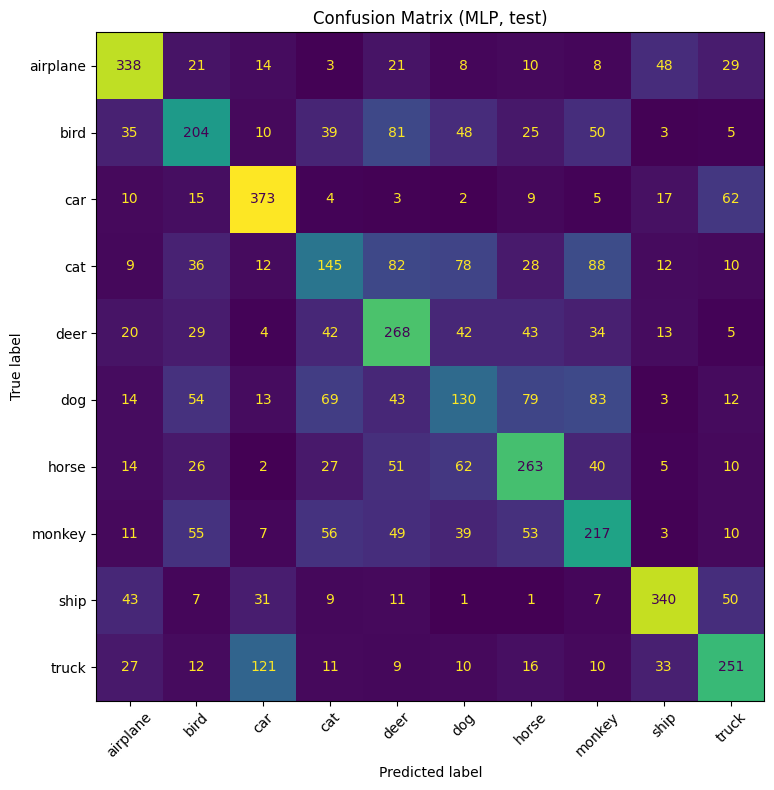

In [41]:
class_names = [id_to_name[idx_to_label[i]] for i in range(num_classes)]

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix (MLP, test)")
plt.tight_layout()
plt.show()


In [42]:
df_perclass = pd.DataFrame({
    "class": class_names,
    "acc_per_class": per_class_acc,
    "support": cm.sum(axis=1)
}).sort_values("acc_per_class")

df_perclass


class  acc_per_class  support
5       dog          0.260      500
3       cat          0.290      500
1      bird          0.408      500
7    monkey          0.434      500
9     truck          0.502      500
6     horse          0.526      500
4      deer          0.536      500
0  airplane          0.676      500
8      ship          0.680      500
2       car          0.746      500

# 2. CNN pe Imagebits

1) Construim un baseline CNN pentru clasificare
2) Folosim split intern train/val (stratificat) deoarece dataset-ul oferă doar train/test.
3) Comparam antrenarea fără augmentări vs. cu augmentări (Albumentations) pe aceleași grafice.


## Transformări (Albumentations)

- Fără augmentări: doar normalizare.
- Cu augmentări: flip orizontal + mici variații de culoare + mici transformări geometrice.


In [43]:
import albumentations as A

tfm_noaug = A.Compose([
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])

tfm_aug = A.Compose([
    A.RandomResizedCrop(size=(96, 96), scale=(0.85, 1.0), ratio=(0.9, 1.1), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_ds_noaug = ImageBitsDataset(df_train, tfm_noaug, flatten=False)
val_ds_noaug   = ImageBitsDataset(df_val,   tfm_noaug, flatten=False)

train_ds_aug = ImageBitsDataset(df_train, tfm_aug, flatten=False)
val_ds_aug   = ImageBitsDataset(df_val,   tfm_noaug, flatten=False) 

train_loader_noaug = DataLoader(train_ds_noaug, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_noaug   = DataLoader(val_ds_noaug,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_aug   = DataLoader(val_ds_aug,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


## Arhitectura CNN pe Imagebits

Alegem un CNN “baseline” simplu:
- Blocuri Convolution + BatchNorm + ReLU: extrag trăsături tot mai abstracte.
- MaxPooling: reduce rezoluția (96→48→24→12), crește invarianta la translații mici și reduce costul.
- Global Average Pooling: reduce numărul de parametri din head (față de flatten), ajutând la reducerea overfitting-ului.
- Dropout înainte de stratul final: regularizare suplimentară.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, dropout=0.3):
        super().__init__()
        self.features = nn.Sequential(
            # 96x96
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 48x48

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 24x24

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  #  [B,128,1,1]
            nn.Flatten(),             #  [B,128]
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [46]:
cnn = SimpleCNN(num_classes=num_classes, dropout=0.3).to(device)
num_params = sum(p.numel() for p in cnn.parameters())
num_params_trainable = sum(p.numel() for p in cnn.parameters() if p.requires_grad)

print(f"Total params: {num_params:,}")
print(f"Trainable params: {num_params_trainable:,}")
print(f"In millions: {num_params/1e6:.3f} M")


Total params: 94,986
Trainable params: 94,986
In millions: 0.095 M


In [ ]:
import torch.optim as optim

def train_cnn_model(train_loader, val_loader,
                    dropout=0.3,
                    epochs=50, lr=1e-3, weight_decay=1e-4,
                    patience=7, min_delta=1e-4):

    model = SimpleCNN(num_classes=num_classes, dropout=dropout).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

    best_val = -1.0
    best_state = None
    best_epoch = None
    best_snapshot = None
    bad_epochs = 0
    stopped_early = False

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer=optimizer)
        va_loss, va_acc, va_f1 = run_epoch(model, val_loader, optimizer=None)

        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        history["train_f1"].append(tr_f1);     history["val_f1"].append(va_f1)

        improved = (va_f1 > best_val + min_delta)
        if improved:
            best_val = va_f1
            best_epoch = ep
            best_snapshot = {
                "train_loss": tr_loss, "train_acc": tr_acc, "train_f1": tr_f1,
                "val_loss": va_loss,   "val_acc": va_acc,   "val_f1": va_f1
            }
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1

        print(f"Epoch {ep:02d} | train loss {tr_loss:.3f} acc {tr_acc:.3f} f1 {tr_f1:.3f} "
              f"| val loss {va_loss:.3f} acc {va_acc:.3f} f1 {va_f1:.3f} "
              f"| bad_epochs={bad_epochs}/{patience}")

        if bad_epochs >= patience:
            stopped_early = True
            print(f"Early stopping: no val_f1 improvement for {patience} epochs.")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    if best_snapshot is None:
        print("Training finished, but no valid improvement was recorded.")
    else:
        why = "EARLY STOP" if stopped_early else "FULL RUN"
        print(
            f"[{why}] Best epoch = {best_epoch:02d} | "
            f"train: loss {best_snapshot['train_loss']:.3f} acc {best_snapshot['train_acc']:.3f} f1 {best_snapshot['train_f1']:.3f} | "
            f"val: loss {best_snapshot['val_loss']:.3f} acc {best_snapshot['val_acc']:.3f} f1 {best_snapshot['val_f1']:.3f}"
        )

    history["best_epoch"] = best_epoch
    history["best_val_f1"] = float(best_val) if best_snapshot is not None else None

    return model, history


- rulare fara augmentari

In [48]:
cnn_noaug, hist_cnn_noaug = train_cnn_model(
    train_loader_noaug, val_loader_noaug,
    dropout=0.3, epochs=50, lr=1e-3, weight_decay=1e-4
)


Epoch 01 | train loss 1.885 acc 0.298 f1 0.288 | val loss 1.694 acc 0.363 f1 0.333 | bad_epochs=0/7
Epoch 02 | train loss 1.615 acc 0.377 f1 0.369 | val loss 1.544 acc 0.410 f1 0.385 | bad_epochs=0/7
Epoch 03 | train loss 1.517 acc 0.422 f1 0.418 | val loss 1.486 acc 0.441 f1 0.427 | bad_epochs=0/7
Epoch 04 | train loss 1.451 acc 0.449 f1 0.444 | val loss 1.468 acc 0.448 f1 0.438 | bad_epochs=0/7
Epoch 05 | train loss 1.402 acc 0.483 f1 0.479 | val loss 1.421 acc 0.448 f1 0.427 | bad_epochs=1/7
Epoch 06 | train loss 1.367 acc 0.489 f1 0.485 | val loss 1.341 acc 0.506 f1 0.501 | bad_epochs=0/7
Epoch 07 | train loss 1.328 acc 0.515 f1 0.512 | val loss 1.400 acc 0.462 f1 0.447 | bad_epochs=1/7
Epoch 08 | train loss 1.288 acc 0.527 f1 0.524 | val loss 1.435 acc 0.466 f1 0.439 | bad_epochs=2/7
Epoch 09 | train loss 1.278 acc 0.525 f1 0.521 | val loss 1.346 acc 0.489 f1 0.485 | bad_epochs=3/7
Epoch 10 | train loss 1.242 acc 0.545 f1 0.543 | val loss 1.426 acc 0.464 f1 0.452 | bad_epochs=4/7


- rulare cu augmentari

In [49]:
cnn_aug, hist_cnn_aug = train_cnn_model(
    train_loader_aug, val_loader_aug,
    dropout=0.3, epochs=50, lr=1e-3, weight_decay=1e-4
)


Epoch 01 | train loss 1.952 acc 0.271 f1 0.255 | val loss 1.740 acc 0.334 f1 0.283 | bad_epochs=0/7
Epoch 02 | train loss 1.732 acc 0.344 f1 0.335 | val loss 1.613 acc 0.371 f1 0.349 | bad_epochs=0/7
Epoch 03 | train loss 1.671 acc 0.364 f1 0.356 | val loss 1.539 acc 0.416 f1 0.396 | bad_epochs=0/7
Epoch 04 | train loss 1.594 acc 0.394 f1 0.390 | val loss 1.613 acc 0.386 f1 0.358 | bad_epochs=1/7
Epoch 05 | train loss 1.543 acc 0.424 f1 0.419 | val loss 1.518 acc 0.407 f1 0.385 | bad_epochs=2/7
Epoch 06 | train loss 1.507 acc 0.437 f1 0.431 | val loss 1.452 acc 0.439 f1 0.418 | bad_epochs=0/7
Epoch 07 | train loss 1.473 acc 0.454 f1 0.449 | val loss 1.428 acc 0.460 f1 0.444 | bad_epochs=0/7
Epoch 08 | train loss 1.448 acc 0.462 f1 0.456 | val loss 1.407 acc 0.472 f1 0.446 | bad_epochs=0/7
Epoch 09 | train loss 1.429 acc 0.471 f1 0.467 | val loss 1.500 acc 0.389 f1 0.354 | bad_epochs=1/7
Epoch 10 | train loss 1.389 acc 0.487 f1 0.483 | val loss 1.386 acc 0.477 f1 0.450 | bad_epochs=0/7


In [50]:
tfm_aug_safe = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.05, rotate_limit=10, p=0.4),
    A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03, p=0.4),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])

train_loader_aug_safe = DataLoader(
    ImageBitsDataset(df_train, tfm_aug_safe, flatten=False),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    ImageBitsDataset(df_val, tfm_noaug, flatten=False),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [51]:
cnn_aug_safe, hist_cnn_aug_safe = train_cnn_model(
    train_loader_aug_safe, val_loader,
    dropout=0.3, epochs=60, lr=3e-4, weight_decay=1e-4
)


Epoch 01 | train loss 2.024 acc 0.249 f1 0.234 | val loss 1.826 acc 0.356 f1 0.334 | bad_epochs=0/7
Epoch 02 | train loss 1.798 acc 0.319 f1 0.307 | val loss 1.701 acc 0.377 f1 0.354 | bad_epochs=0/7
Epoch 03 | train loss 1.702 acc 0.357 f1 0.349 | val loss 1.614 acc 0.427 f1 0.416 | bad_epochs=0/7
Epoch 04 | train loss 1.644 acc 0.384 f1 0.378 | val loss 1.554 acc 0.414 f1 0.386 | bad_epochs=1/7
Epoch 05 | train loss 1.576 acc 0.416 f1 0.411 | val loss 1.494 acc 0.456 f1 0.447 | bad_epochs=0/7
Epoch 06 | train loss 1.540 acc 0.428 f1 0.425 | val loss 1.458 acc 0.468 f1 0.455 | bad_epochs=0/7
Epoch 07 | train loss 1.508 acc 0.449 f1 0.445 | val loss 1.436 acc 0.479 f1 0.478 | bad_epochs=0/7
Epoch 08 | train loss 1.478 acc 0.456 f1 0.452 | val loss 1.426 acc 0.474 f1 0.469 | bad_epochs=1/7
Epoch 09 | train loss 1.454 acc 0.463 f1 0.460 | val loss 1.393 acc 0.493 f1 0.483 | bad_epochs=0/7
Epoch 10 | train loss 1.436 acc 0.469 f1 0.465 | val loss 1.380 acc 0.484 f1 0.475 | bad_epochs=1/7


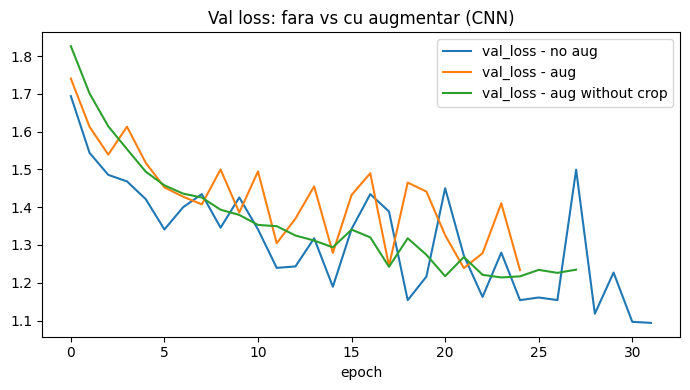

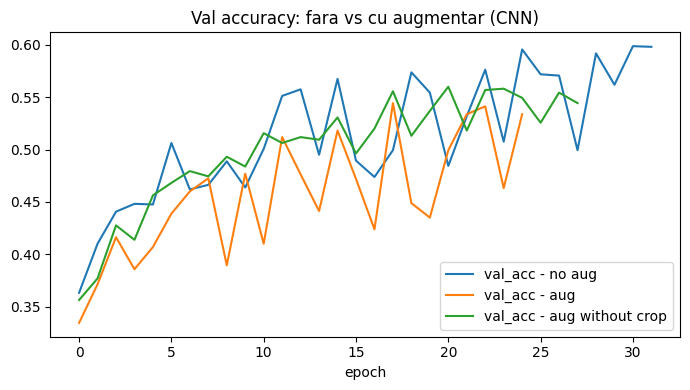

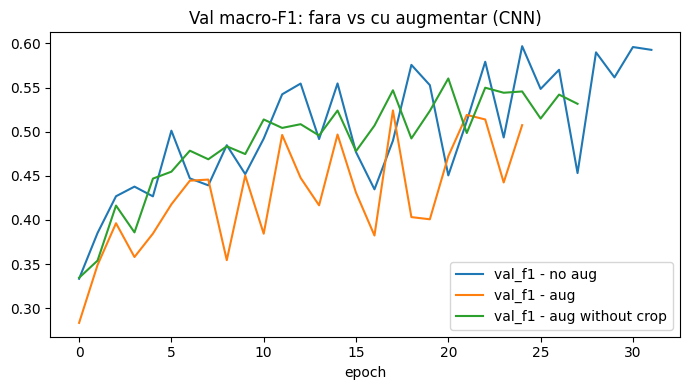

In [52]:
def plot_compare3(hist1, hist2, hist3, key, title):
    plt.figure(figsize=(7,4))
    plt.plot(hist1[key], label=f"{key} - no aug")
    plt.plot(hist2[key], label=f"{key} - aug")
    plt.plot(hist3[key], label=f"{key} - aug without crop")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_compare3(hist_cnn_noaug, hist_cnn_aug, hist_cnn_aug_safe, "val_loss", "Val loss: fara vs cu augmentar (CNN)")
plot_compare3(hist_cnn_noaug, hist_cnn_aug, hist_cnn_aug_safe, "val_acc",  "Val accuracy: fara vs cu augmentar (CNN)")
plot_compare3(hist_cnn_noaug, hist_cnn_aug, hist_cnn_aug_safe, "val_f1",   "Val macro-F1: fara vs cu augmentar (CNN)")

Se poate observa, contrat asteptarilor, ca modelul fara augmentari are cel mai bun f1 score. Vom alege aceasta configuratie si vom incerca sa o optimizam.

In [53]:
cnn_noaug_lr34, hist_cnn_noaug_lr34 = train_cnn_model(
    train_loader_noaug, val_loader_noaug,
    dropout=0.3, epochs=60, lr=3e-4, weight_decay=1e-4,
    patience=10
)


Epoch 01 | train loss 2.020 acc 0.253 f1 0.236 | val loss 1.854 acc 0.311 f1 0.260 | bad_epochs=0/10
Epoch 02 | train loss 1.780 acc 0.333 f1 0.323 | val loss 1.697 acc 0.388 f1 0.377 | bad_epochs=0/10
Epoch 03 | train loss 1.672 acc 0.376 f1 0.371 | val loss 1.611 acc 0.424 f1 0.410 | bad_epochs=0/10
Epoch 04 | train loss 1.585 acc 0.410 f1 0.406 | val loss 1.525 acc 0.440 f1 0.433 | bad_epochs=0/10
Epoch 05 | train loss 1.525 acc 0.446 f1 0.442 | val loss 1.495 acc 0.485 f1 0.485 | bad_epochs=0/10
Epoch 06 | train loss 1.485 acc 0.460 f1 0.455 | val loss 1.470 acc 0.463 f1 0.454 | bad_epochs=1/10
Epoch 07 | train loss 1.461 acc 0.460 f1 0.457 | val loss 1.428 acc 0.477 f1 0.464 | bad_epochs=2/10
Epoch 08 | train loss 1.416 acc 0.486 f1 0.482 | val loss 1.389 acc 0.504 f1 0.494 | bad_epochs=0/10
Epoch 09 | train loss 1.403 acc 0.478 f1 0.475 | val loss 1.360 acc 0.512 f1 0.509 | bad_epochs=0/10
Epoch 10 | train loss 1.373 acc 0.497 f1 0.493 | val loss 1.353 acc 0.509 f1 0.503 | bad_ep

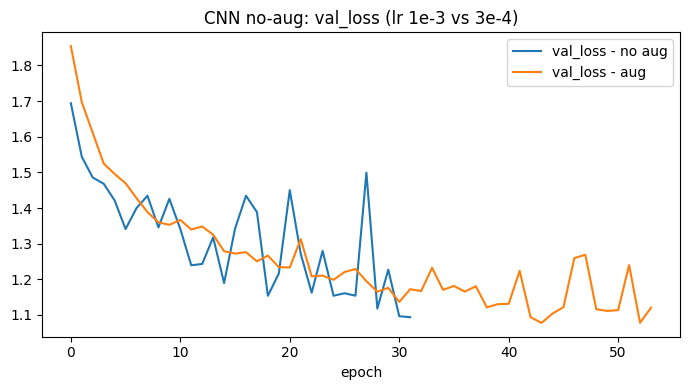

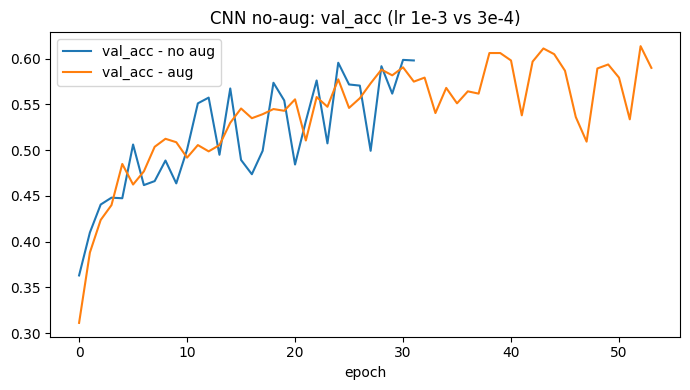

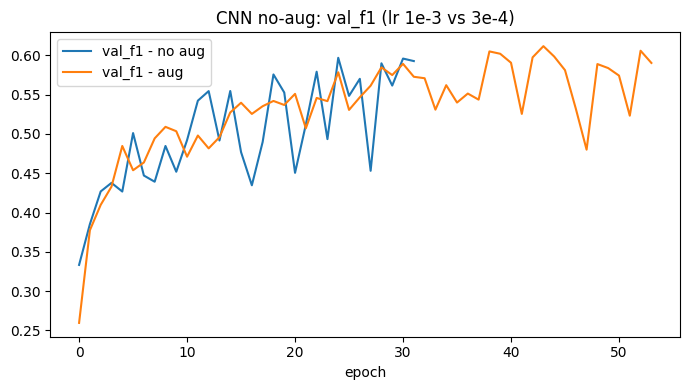

In [54]:
plot_compare(hist_cnn_noaug, hist_cnn_noaug_lr34, "val_loss", "CNN no-aug: val_loss (lr 1e-3 vs 3e-4)")
plot_compare(hist_cnn_noaug, hist_cnn_noaug_lr34, "val_acc",  "CNN no-aug: val_acc (lr 1e-3 vs 3e-4)")
plot_compare(hist_cnn_noaug, hist_cnn_noaug_lr34, "val_f1",   "CNN no-aug: val_f1 (lr 1e-3 vs 3e-4)")


Nici aceasta configuratie nu a reusit sa dea un scor f1 mai bun decat cea cu lr 1e-4 si nicio augmentare, deci ne vom concentra pe pastrarea acele configuratii si vom incerca sa imbunatatim arhitectura

In [55]:
import torch
import torch.nn as nn

class CNNv2(nn.Module):
    def __init__(self, num_classes=10, base=64, dropout=0.3):
        super().__init__()

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.MaxPool2d(kernel_size=2)  # /2 spatial
            )

        self.features = nn.Sequential(
            block(3, base),          # 96 -> 48
            block(base, base*2),     # 48 -> 24
            block(base*2, base*4),   # 24 -> 12
            block(base*4, base*4),   # 12 -> 6
        )

        self.pool = nn.AdaptiveAvgPool2d((1,1))  # 6x6 -> 1x1
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(base*4, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [56]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

cnn_tmp = CNNv2(num_classes=num_classes, base=64, dropout=0.3).to(device)
count_params(cnn_tmp)/1e6


2.329546

In [57]:
import torch.optim as optim

def train_cnn_model_v2(train_loader, val_loader,
                    base=64, dropout=0.3,
                    epochs=50, lr=1e-3, weight_decay=1e-4,
                    patience=10, min_delta=1e-4):

    model = CNNv2(num_classes=num_classes, base=base, dropout=dropout).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

    best_val = -1.0
    best_state = None
    bad_epochs = 0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer=optimizer)
        va_loss, va_acc, va_f1 = run_epoch(model, val_loader, optimizer=None)

        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        history["train_f1"].append(tr_f1);     history["val_f1"].append(va_f1)

        improved = (va_f1 > best_val + min_delta)
        if improved:
            best_val = va_f1
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1

        print(f"Epoch {ep:02d} | train loss {tr_loss:.3f} acc {tr_acc:.3f} f1 {tr_f1:.3f} "
              f"| val loss {va_loss:.3f} acc {va_acc:.3f} f1 {va_f1:.3f} "
              f"| bad_epochs={bad_epochs}/{patience}")

        if bad_epochs >= patience:
            print(f"Early stopping: no val_f1 improvement for {patience} epochs. Best val_f1={best_val:.4f}")
            break

    model.load_state_dict(best_state)
    return model, history


In [58]:
import albumentations as A

tfm_noaug = A.Compose([
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])

tfm_aug_safe = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [59]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_ds_noaug = ImageBitsDataset(df_train, tfm_noaug, flatten=False)
val_ds_noaug   = ImageBitsDataset(df_val,   tfm_noaug, flatten=False)

train_ds_aug   = ImageBitsDataset(df_train, tfm_aug_safe, flatten=False)
val_ds_aug     = ImageBitsDataset(df_val,   tfm_noaug,    flatten=False)  # val fără aug

train_loader_noaug = DataLoader(train_ds_noaug, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_noaug   = DataLoader(val_ds_noaug,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_aug   = DataLoader(val_ds_aug,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [60]:
cnn2_noaug, hist_cnn2_noaug = train_cnn_model_v2(
    train_loader_noaug, val_loader_noaug,
    base=64, dropout=0.3, epochs=60, lr=1e-3, weight_decay=1e-4,
    patience=10
)



Epoch 01 | train loss 1.726 acc 0.323 f1 0.310 | val loss 1.720 acc 0.354 f1 0.340 | bad_epochs=0/10
Epoch 02 | train loss 1.436 acc 0.447 f1 0.442 | val loss 1.789 acc 0.404 f1 0.362 | bad_epochs=0/10
Epoch 03 | train loss 1.266 acc 0.520 f1 0.517 | val loss 2.019 acc 0.364 f1 0.306 | bad_epochs=1/10
Epoch 04 | train loss 1.158 acc 0.573 f1 0.570 | val loss 1.525 acc 0.479 f1 0.460 | bad_epochs=0/10
Epoch 05 | train loss 1.046 acc 0.613 f1 0.611 | val loss 1.142 acc 0.576 f1 0.557 | bad_epochs=0/10
Epoch 06 | train loss 0.991 acc 0.633 f1 0.631 | val loss 1.176 acc 0.570 f1 0.563 | bad_epochs=0/10
Epoch 07 | train loss 0.912 acc 0.672 f1 0.671 | val loss 1.171 acc 0.573 f1 0.577 | bad_epochs=0/10
Epoch 08 | train loss 0.841 acc 0.697 f1 0.696 | val loss 1.263 acc 0.552 f1 0.534 | bad_epochs=1/10
Epoch 09 | train loss 0.794 acc 0.712 f1 0.711 | val loss 1.232 acc 0.579 f1 0.559 | bad_epochs=2/10
Epoch 10 | train loss 0.748 acc 0.730 f1 0.730 | val loss 1.422 acc 0.553 f1 0.529 | bad_ep

In [61]:
cnn2_aug, hist_cnn2_aug = train_cnn_model_v2(
    train_loader_aug, val_loader_aug,
    base=64, dropout=0.3, epochs=60, lr=1e-3, weight_decay=1e-4,
    patience=10
)

Epoch 01 | train loss 1.755 acc 0.331 f1 0.320 | val loss 1.713 acc 0.342 f1 0.312 | bad_epochs=0/10
Epoch 02 | train loss 1.476 acc 0.436 f1 0.431 | val loss 1.565 acc 0.412 f1 0.376 | bad_epochs=0/10
Epoch 03 | train loss 1.312 acc 0.507 f1 0.503 | val loss 1.614 acc 0.404 f1 0.367 | bad_epochs=1/10
Epoch 04 | train loss 1.215 acc 0.552 f1 0.548 | val loss 1.350 acc 0.511 f1 0.495 | bad_epochs=0/10
Epoch 05 | train loss 1.121 acc 0.584 f1 0.580 | val loss 1.459 acc 0.500 f1 0.476 | bad_epochs=1/10
Epoch 06 | train loss 1.089 acc 0.600 f1 0.598 | val loss 1.268 acc 0.542 f1 0.516 | bad_epochs=0/10
Epoch 07 | train loss 1.013 acc 0.630 f1 0.628 | val loss 1.455 acc 0.489 f1 0.447 | bad_epochs=1/10
Epoch 08 | train loss 0.971 acc 0.646 f1 0.645 | val loss 1.375 acc 0.519 f1 0.496 | bad_epochs=2/10
Epoch 09 | train loss 0.919 acc 0.666 f1 0.664 | val loss 1.084 acc 0.616 f1 0.599 | bad_epochs=0/10
Epoch 10 | train loss 0.880 acc 0.679 f1 0.678 | val loss 1.884 acc 0.449 f1 0.424 | bad_ep

In [72]:
cnn2_noaug_lr3e4, hist_cnn2_noaug_lr3e4 = train_cnn_model_v2(
    train_loader_noaug, val_loader_noaug,
    base=64, dropout=0.3, epochs=60, lr=3e-4, weight_decay=1e-4,
    patience=10
)

Epoch 01 | train loss 1.650 acc 0.356 f1 0.349 | val loss 1.563 acc 0.397 f1 0.376 | bad_epochs=0/10
Epoch 02 | train loss 1.334 acc 0.501 f1 0.497 | val loss 1.426 acc 0.444 f1 0.423 | bad_epochs=0/10
Epoch 03 | train loss 1.191 acc 0.566 f1 0.562 | val loss 1.244 acc 0.551 f1 0.538 | bad_epochs=0/10
Epoch 04 | train loss 1.088 acc 0.603 f1 0.600 | val loss 1.381 acc 0.484 f1 0.459 | bad_epochs=1/10
Epoch 05 | train loss 0.990 acc 0.640 f1 0.638 | val loss 1.280 acc 0.531 f1 0.517 | bad_epochs=2/10
Epoch 06 | train loss 0.906 acc 0.678 f1 0.677 | val loss 1.164 acc 0.563 f1 0.557 | bad_epochs=0/10
Epoch 07 | train loss 0.853 acc 0.693 f1 0.692 | val loss 1.284 acc 0.559 f1 0.552 | bad_epochs=1/10
Epoch 08 | train loss 0.783 acc 0.724 f1 0.724 | val loss 1.168 acc 0.567 f1 0.554 | bad_epochs=2/10
Epoch 09 | train loss 0.706 acc 0.755 f1 0.755 | val loss 1.233 acc 0.589 f1 0.565 | bad_epochs=0/10
Epoch 10 | train loss 0.636 acc 0.786 f1 0.786 | val loss 1.673 acc 0.528 f1 0.525 | bad_ep

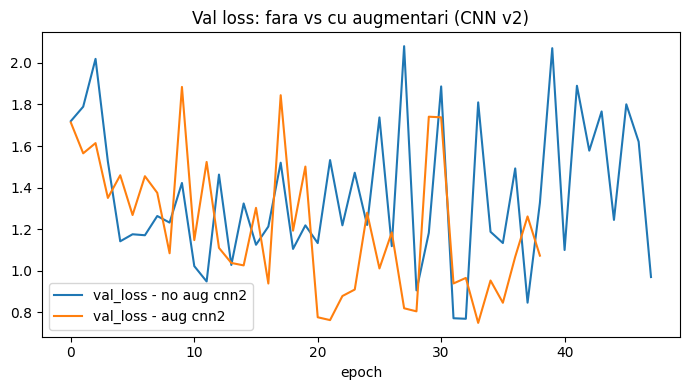

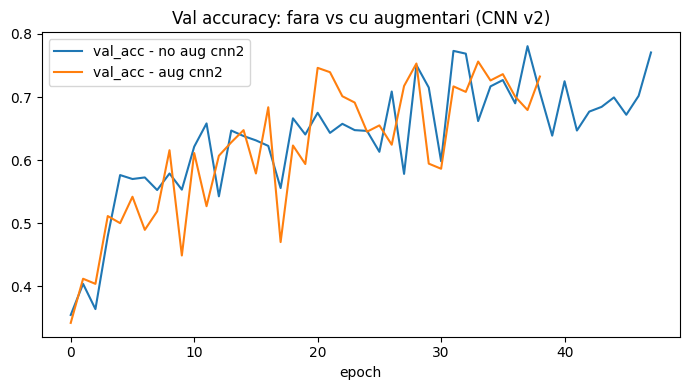

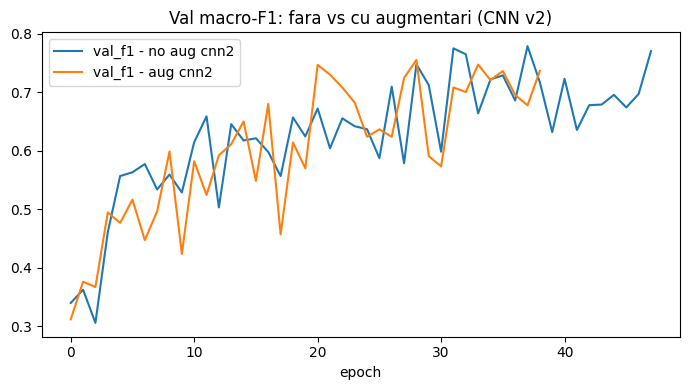

In [73]:
def plot_compare(hist1, hist2, key, title):
    plt.figure(figsize=(7,4))
    plt.plot(hist1[key], label=f"{key} - no aug cnn2")
    plt.plot(hist2[key], label=f"{key} - aug cnn2")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_compare(hist_cnn2_noaug, hist_cnn2_aug, "val_loss", "Val loss: fara vs cu augmentari (CNN v2)")
plot_compare(hist_cnn2_noaug, hist_cnn2_aug, "val_acc",  "Val accuracy: fara vs cu augmentari (CNN v2)")
plot_compare(hist_cnn2_noaug, hist_cnn2_aug, "val_f1",   "Val macro-F1: fara vs cu augmentari (CNN v2)")


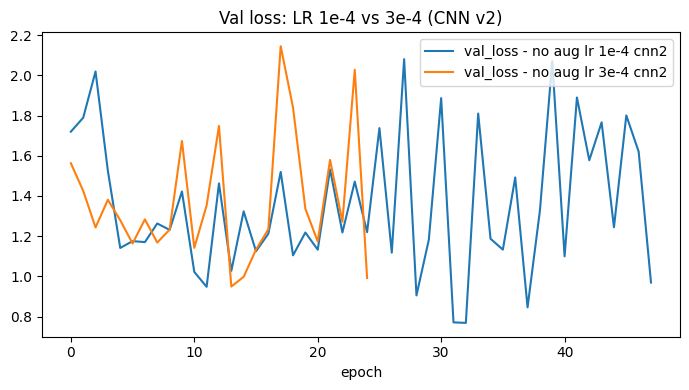

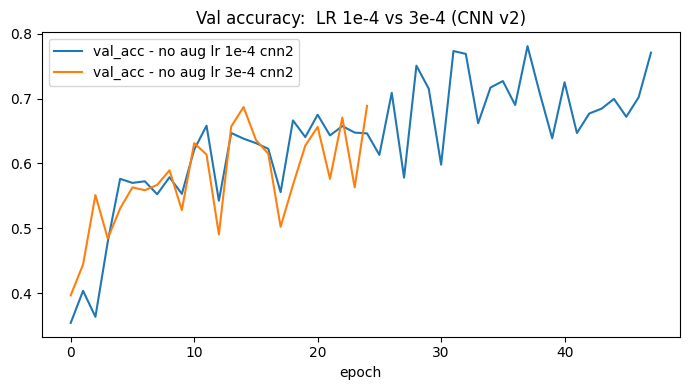

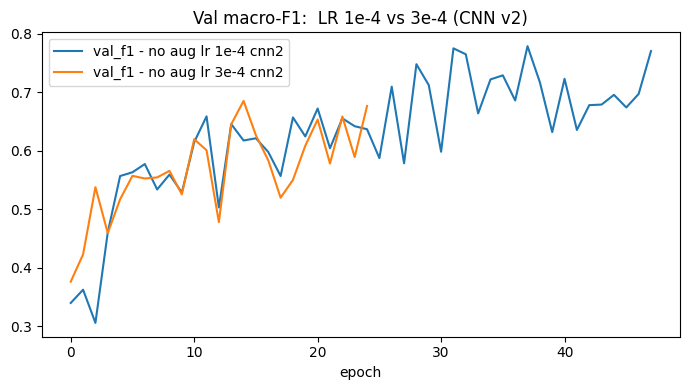

In [74]:
def plot_compare(hist1, hist2, key, title):
    plt.figure(figsize=(7,4))
    plt.plot(hist1[key], label=f"{key} - no aug lr 1e-4 cnn2")
    plt.plot(hist2[key], label=f"{key} - no aug lr 3e-4 cnn2")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_compare(hist_cnn2_noaug, hist_cnn2_noaug_lr3e4, "val_loss", "Val loss: LR 1e-4 vs 3e-4 (CNN v2)")
plot_compare(hist_cnn2_noaug, hist_cnn2_noaug_lr3e4, "val_acc",  "Val accuracy:  LR 1e-4 vs 3e-4 (CNN v2)")
plot_compare(hist_cnn2_noaug, hist_cnn2_noaug_lr3e4, "val_f1",   "Val macro-F1:  LR 1e-4 vs 3e-4 (CNN v2)")

Alegem ultima configuratie, avand cel mai bun f1 score si trecem la partea de test

In [75]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch
import torch.nn as nn

@torch.no_grad()
def eval_with_preds(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    losses = []
    all_y, all_p = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        losses.append(loss.item())
        preds = logits.argmax(dim=1)

        all_y.append(y.cpu().numpy())
        all_p.append(preds.cpu().numpy())

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)

    loss = float(np.mean(losses))
    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, average="macro")
    return loss, acc, f1, y_true, y_pred


In [76]:
test_loader_cnn = DataLoader(
    ImageBitsDataset(df_test, tfm_noaug, flatten=False),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

test_loss, test_acc, test_f1, y_true, y_pred = eval_with_preds(cnn2_noaug, test_loader_cnn)
print(f"TEST | loss {test_loss:.3f} acc {test_acc:.4f} macro-F1 {test_f1:.4f}")


TEST | loss 0.898 acc 0.7830 macro-F1 0.7817


- save checkpoint

In [ ]:
import torch
from pathlib import Path

CKPT_PATH = Path("/kaggle/working/cnn_imagebits_best.pth")

cnn_best = cnn2_noaug

ckpt = {
    "model_state_dict": cnn_best.state_dict(),
    "num_classes": num_classes,              
    "mean_rgb": mean_rgb.tolist(),           
    "std_rgb": std_rgb.tolist(),
    "label_to_idx": label_to_idx,            
    "id_to_name": id_to_name,                
    "arch": "CNNv2",                        
    "train_cfg": {
        "lr": 3e-4,
        "weight_decay": 1e-4,
        "batch_size": BATCH_SIZE,
    }
}

torch.save(ckpt, CKPT_PATH)
print("Saved:", CKPT_PATH, "size(MB)=", CKPT_PATH.stat().st_size/1e6)
print("Final model to save:", type(cnn_best).__name__)
print("Test metrics:", test_loss, test_acc, test_f1)



Saved: /kaggle/working/cnn_imagebits_best.pth size(MB)= 9.348149
Final model to save: CNNv2
Test metrics: 0.898028339445591 0.783 0.7817051894510202


In [78]:
from pathlib import Path
CKPT_PATH = Path("/kaggle/working/cnn_imagebits_best.pth")
print("exists:", CKPT_PATH.exists())
print("size MB:", CKPT_PATH.stat().st_size/1e6 if CKPT_PATH.exists() else None)


exists: True
size MB: 9.348149


In [79]:
import torch
from pathlib import Path

CKPT_PATH = Path("/kaggle/working/cnn_imagebits_best.pth")
ckpt = torch.load(CKPT_PATH, map_location="cpu")
print(ckpt.keys())
print("arch:", ckpt.get("arch"))
print("num_classes:", ckpt.get("num_classes"))


dict_keys(['model_state_dict', 'num_classes', 'mean_rgb', 'std_rgb', 'label_to_idx', 'id_to_name', 'arch', 'train_cfg'])
arch: CNNv2
num_classes: 10


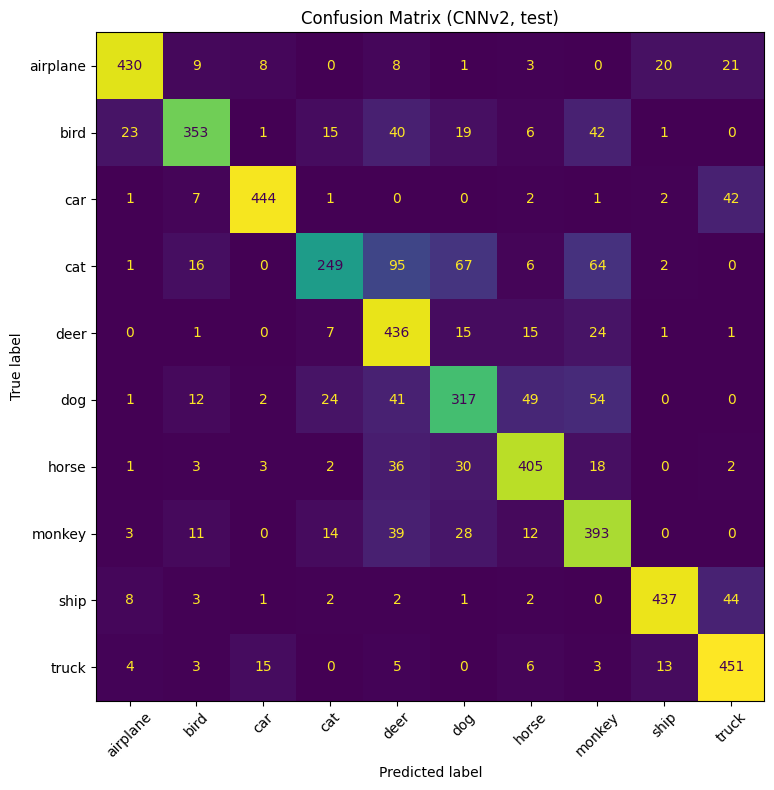

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

class_names = [id_to_name[str(i)] for i in range(1, num_classes+1)]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix (CNNv2, test)")
plt.tight_layout()
plt.show()

In [81]:
df_perclass = pd.DataFrame({
    "class": class_names,
    "acc_per_class": per_class_acc,
    "support": cm.sum(axis=1)
}).sort_values("acc_per_class")

df_perclass

class  acc_per_class  support
3       cat          0.498      500
5       dog          0.634      500
1      bird          0.706      500
7    monkey          0.786      500
6     horse          0.810      500
0  airplane          0.860      500
4      deer          0.872      500
8      ship          0.874      500
2       car          0.888      500
9     truck          0.902      500